# Activity 3B: ANN

In [1]:
# ============================================================================
# CELL 1: Imports and Setup
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [2]:


# ============================================================================
# CELL 2: Load and Prepare Data
# ============================================================================
# Load dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

print(f"Dataset shape: {X.shape}")
print(f"Features: {housing.feature_names}")
print(f"Target range: ${y.min():.2f} - ${y.max():.2f} (in $100,000s)")

# Split into train/val/test (55%/15%/30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.45, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Val set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)


Dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target range: $0.15 - $5.00 (in $100,000s)

Train set: 11352 samples
Val set: 3065 samples
Test set: 6223 samples


In [3]:


# ============================================================================
# CELL 3: Define Model Architecture
# ============================================================================
def create_model(input_size, hidden_size, dropout_rate):
    """Create a simple feedforward neural network"""
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_size, hidden_size // 2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_size // 2, 1)
    )
    return model


In [4]:

# ============================================================================
# CELL 4: Training Function with Early Stopping
# ============================================================================
def train_with_early_stopping(model, train_loader, val_loader, lr, epochs, patience):
    """Train model with early stopping"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping at epoch {epoch+1}')
                model.load_state_dict(best_model_state)
                break
    
    return train_losses, val_losses, best_val_loss


In [5]:


# ============================================================================
# CELL 5: Evaluation Metrics
# ============================================================================
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    y_true = y_true.numpy() if torch.is_tensor(y_true) else y_true
    y_pred = y_pred.numpy() if torch.is_tensor(y_pred) else y_pred
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def evaluate_model(model, X, y):
    """Evaluate model and return metrics"""
    model.eval()
    with torch.no_grad():
        predictions = model(X)
        mse = nn.MSELoss()(predictions, y).item()
        rmse = np.sqrt(mse)
        mape = calculate_mape(y, predictions)
    return mse, rmse, mape, predictions



In [6]:


# ============================================================================
# CELL 6: Grid Search Parameters (STUDENTS CAN TWEAK HERE!)
# ============================================================================
# Define hyperparameter grid
param_grid = [
    {'hidden_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001},
    {'hidden_size': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001},
    {'hidden_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'hidden_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001},
]

# Training settings
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 10  # Early stopping patience

print("Grid Search Parameters:")
for i, params in enumerate(param_grid):
    print(f"  Config {i+1}: {params}")


Grid Search Parameters:
  Config 1: {'hidden_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001}
  Config 2: {'hidden_size': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001}
  Config 3: {'hidden_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}
  Config 4: {'hidden_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001}


In [7]:


# ============================================================================
# CELL 7: Run Grid Search
# ============================================================================
print("\n" + "="*60)
print("STARTING GRID SEARCH")
print("="*60)

results = []

for i, params in enumerate(param_grid):
    print(f"\n--- Configuration {i+1}/{len(param_grid)} ---")
    print(f"Parameters: {params}")
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    # Create model
    model = create_model(
        input_size=X_train.shape[1],
        hidden_size=params['hidden_size'],
        dropout_rate=params['dropout_rate']
    )
    
    # Train
    train_losses, val_losses, best_val_loss = train_with_early_stopping(
        model, train_loader, val_loader,
        lr=params['learning_rate'],
        epochs=EPOCHS,
        patience=PATIENCE
    )
    
    # Store results
    results.append({
        'config': i+1,
        'params': params,
        'best_val_loss': best_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'model': model
    })
    
    print(f"Best Val Loss: {best_val_loss:.4f}")

# Find best configuration
best_result = min(results, key=lambda x: x['best_val_loss'])
print("\n" + "="*60)
print("GRID SEARCH COMPLETE")
print("="*60)
print(f"\nBest Configuration: #{best_result['config']}")
print(f"Parameters: {best_result['params']}")
print(f"Best Validation Loss: {best_result['best_val_loss']:.4f}")



STARTING GRID SEARCH

--- Configuration 1/4 ---
Parameters: {'hidden_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Epoch 10/100 | Train Loss: 0.4534 | Val Loss: 0.3810
Epoch 20/100 | Train Loss: 0.3775 | Val Loss: 0.3428
Epoch 30/100 | Train Loss: 0.3531 | Val Loss: 0.3285
Epoch 40/100 | Train Loss: 0.3375 | Val Loss: 0.3181
Epoch 50/100 | Train Loss: 0.3258 | Val Loss: 0.3166
Epoch 60/100 | Train Loss: 0.3284 | Val Loss: 0.3084
Epoch 70/100 | Train Loss: 0.3165 | Val Loss: 0.3044
Epoch 80/100 | Train Loss: 0.3211 | Val Loss: 0.2973
Epoch 90/100 | Train Loss: 0.3166 | Val Loss: 0.3055

Early stopping at epoch 90
Best Val Loss: 0.2973

--- Configuration 2/4 ---
Parameters: {'hidden_size': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Epoch 10/100 | Train Loss: 0.3925 | Val Loss: 0.3678
Epoch 20/100 | Train Loss: 0.3384 | Val Loss: 0.3203
Epoch 30/100 | Train Loss: 0.3089 | Val Loss: 0.3085
Epoch 40/100 | Train Loss: 0.2935 | Val Loss: 0.2955
Epoch 50/100 | Train Loss: 0.2

In [8]:
# ============================================================================
# CELL 8: Model Summary and Final Evaluation
# ============================================================================
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)

best_model = best_result['model']
print("\nModel Architecture:")
print(best_model)

# Count parameters
total_params = sum(p.numel() for p in best_model.parameters())
trainable_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Evaluate on all sets
print("\n" + "-"*60)
print("PERFORMANCE METRICS")
print("-"*60)

train_mse, train_rmse, train_mape, _ = evaluate_model(best_model, X_train, y_train)
val_mse, val_rmse, val_mape, _ = evaluate_model(best_model, X_val, y_val)
test_mse, test_rmse, test_mape, test_pred = evaluate_model(best_model, X_test, y_test)

print(f"\nTrain Set:")
print(f"  MSE:  {train_mse:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

print(f"\nValidation Set:")
print(f"  MSE:  {val_mse:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAPE: {val_mape:.2f}%")

print(f"\nTest Set:")
print(f"  MSE:  {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAPE: {test_mape:.2f}%")



FINAL MODEL SUMMARY

Model Architecture:
Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)

Total parameters: 9,473
Trainable parameters: 9,473

------------------------------------------------------------
PERFORMANCE METRICS
------------------------------------------------------------

Train Set:
  MSE:  0.2327
  RMSE: 0.4824
  MAPE: 18.42%

Validation Set:
  MSE:  0.2885
  RMSE: 0.5371
  MAPE: 20.69%

Test Set:
  MSE:  0.2543
  RMSE: 0.5043
  MAPE: 19.17%


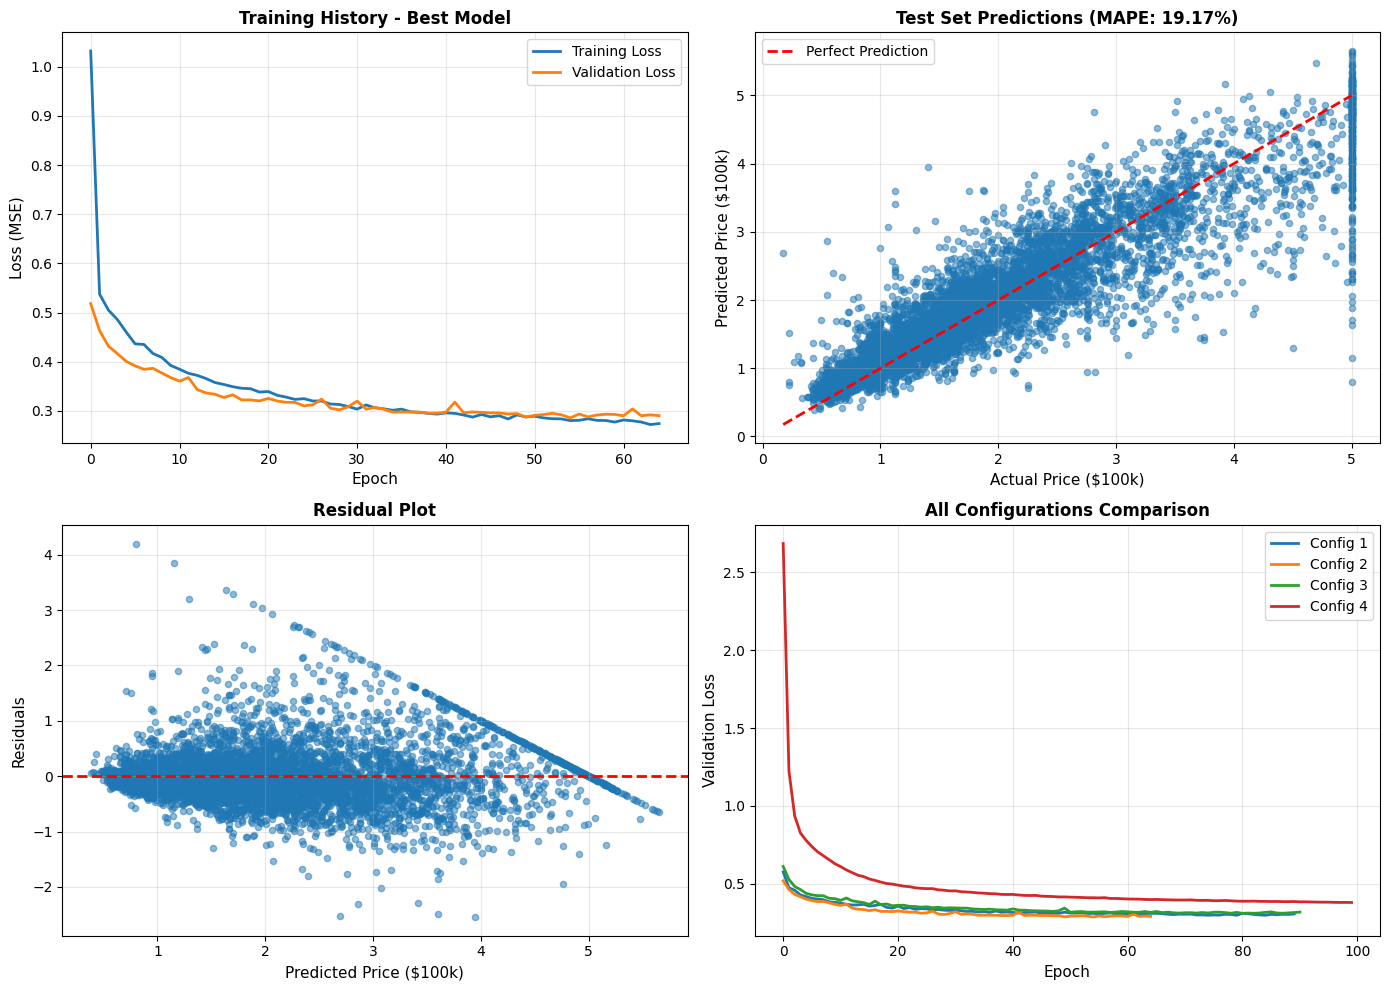


DONE! Students can now tweak parameters in CELL 6 and rerun.


In [9]:
# ============================================================================
# CELL 9: Visualizations
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training history for best model
ax1 = axes[0, 0]
ax1.plot(best_result['train_losses'], label='Training Loss', linewidth=2)
ax1.plot(best_result['val_losses'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss (MSE)', fontsize=11)
ax1.set_title('Training History - Best Model', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual
ax2 = axes[0, 1]
ax2.scatter(y_test.numpy(), test_pred.numpy(), alpha=0.5, s=20)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Price ($100k)', fontsize=11)
ax2.set_ylabel('Predicted Price ($100k)', fontsize=11)
ax2.set_title(f'Test Set Predictions (MAPE: {test_mape:.2f}%)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals
ax3 = axes[1, 0]
residuals = (y_test.numpy() - test_pred.numpy()).flatten()
ax3.scatter(test_pred.numpy(), residuals, alpha=0.5, s=20)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Price ($100k)', fontsize=11)
ax3.set_ylabel('Residuals', fontsize=11)
ax3.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Compare all configurations
ax4 = axes[1, 1]
for result in results:
    label = f"Config {result['config']}"
    ax4.plot(result['val_losses'], label=label, linewidth=2)
ax4.set_xlabel('Epoch', fontsize=11)
ax4.set_ylabel('Validation Loss', fontsize=11)
ax4.set_title('All Configurations Comparison', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DONE!")
print("="*60)

## Q1: Epochs
How can you speed up the grid search process? Could you do with less than 100 epochs?

## Q2: Activation functions
Explore a few other activation functions in the best model. Do you gain any performance improvement by switching from ReLU?

## Q3: Number of layers
Add 2 to 3 more layers to the best model. Can you improve performance with more depth? State your results.

## Q4: Explore
Now try all the possible tricks you have to get the best test MAPE possible. What's your lowest score?